#### Notes:

- Look at percentage change instead of price 
- Look at multivariate regression models

## Train Test split

In [1]:
import pandas as pd
import math
from pandas.plotting import lag_plot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima_model import ARIMA

from tqdm import tqdm_notebook as tqdm

In [2]:
stock_df = pd.read_csv(filepath_or_buffer="C:/Users/limxu/OneDrive/Documents/UCB/SAAS/Project/data/stock_df_full.csv", index_col=0)

In [68]:
global_scores = []

## Setting Variables

In [4]:
def reduceWindow(n, stock_df):
    last_index = len(stock_df)-1
    rand = random.randint(0,last_index-n)
    print("random index is ", rand) 

    #Reduce the size of the df to n
    plot_df = stock_df.iloc[rand:rand+n]

    return plot_df

In [55]:
y_var = 'plus1_open'

y = stock_df[y_var]
X = stock_df[['minus1_change','minus2_change','minus3_change', 'atr', 'macd', 'accdist','roc','open']]
print(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

   minus1_change  minus2_change  minus3_change       atr      macd  \
0       3.308183       1.651917      -4.668166  1.622551  0.304654   
1       5.393258       3.308183       1.651917  1.571655  0.291643   
2      -3.891258       5.393258       3.308183  1.548679  0.260575   
3      -1.220189      -3.891258       5.393258  1.504488  0.190986   
4      -2.975856      -1.220189      -3.891258  1.452739  0.081638   

        accdist        roc   open  
0 -5.036333e+07   2.123027  18.15  
1 -5.065167e+07  -5.005269  18.60  
2 -5.119069e+07  -7.576544  18.75  
3 -5.188138e+07 -10.280374  18.00  
4 -5.224368e+07  -7.922438  17.20  


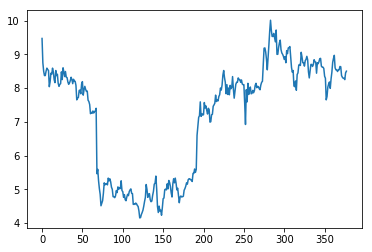

In [56]:
#plot the graph of plus 1 changes against time
x = list(range(0, len(y_test)))
plt.plot(x, y_test)
plt.show()

In [57]:
data_arima=y
X_train_arima, X_test_arima, y_train_arima, y_test_arima = train_test_split(data_arima, data_arima, test_size = 0.2, shuffle=False)

### ML models and function

In [58]:
def getRMSE(model, x, y):
    predictions=list(model.predict(x))
#     print('predictions are ', predictions)
    rmse = mean_squared_error(y, predictions)
    return rmse

def getRMSEarima(model, y, start_index, window):
#     start_index = len(x)
#     end_index = start_index+5 
    #note that we are predicting 5 timesteps into the future
    
#     predictions=list(model.predict(start=1, end = 1+window-1))

    predictions=list(model.forecast(steps=window)[0])
    rmse = mean_squared_error(y, predictions)
    return rmse
    

def evaluateModel(model, n_splits, X_train, y_train):
    scores=[]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    print('test size is %d'% (len(X_train)/n_splits))

    for train_index, validate_index in tqdm(tscv.split(X_train)):      

        cv_train = X_train.iloc[train_index]
        cv_y = y_train.iloc[train_index]
        
        #we are only validating our results on the next 5 timesteps because arima cannot do well in longterm
        cv_validate_train = X_train.iloc[validate_index[:5]]
        cv_validate_y = np.array(y_train.iloc[validate_index[:5]])
        
        if(type(model)==ARIMA):
            print('use other function')
        else:
            model = model.fit(cv_train, cv_y)
            score = getRMSE(model, cv_validate_train, cv_validate_y)
#             score = model.score(cv_validate_train, cv_validate_y)
        scores.append(score)
        
    return scores


def evaluateArimaModel(p, d, q, n_splits, X_train):
    scores=[]
    window = 5

    tscv = TimeSeriesSplit(n_splits=n_splits)
    print('test size is %d'% (len(X_train)/n_splits))

    for train_index, validate_index in tqdm(tscv.split(X_train)):        

        cv_train = X_train.iloc[train_index]
        params=cv_train
        
        #we are only validating our results on the next 5 timesteps because arima cannot do well in longterm
        cv_validate_X = np.array(X_train.iloc[validate_index[:window]])
        
        arima = ARIMA(cv_train, order=(p,d,q))
        arima_fit = arima.fit()
        start_index = len(cv_train)
        score = getRMSEarima(arima_fit, cv_validate_X, start_index, window)
        
#         if(type(model)==ARIMA):
#             model.fit(cv_train) #trend='nc'
#             score = getRMSEarima(model, cv_validate_train, cv_validate_y)

        scores.append(score)
        
    return scores

In [59]:
def trainModel(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    l1= model.predict(X_test)
    
    score = getRMSE(model, X_test, y_test)
#     score = model.score(X_test, y_test)
    print('score is ', score)
    
    x = list(range(0, len(y_test)))
    plt.plot(x, y_test)
    plt.plot(x, l1)
    plt.show()
    
    
    
    return model, score

def trainModelArima(p,d,q, X_train, y_test, window, data_arima):
    predictions = []
    
    start_train_index = len(X_train)-1 
    
    
    for y in tqdm(y_test):
        new_train = data_arima[:start_train_index]
        arima = ARIMA(new_train, order=(p,d,q))
        arima_fit = arima.fit()
        prediction = arima_fit.forecast()[0]
        
        predictions.append(prediction)
        start_train_index +=1 
    
    
#     arima = ARIMA(X_train, order=(p,d,q))
#     arima_fit = arima.fit()
#     start_index = len(X_train)
#     score = getRMSEarima(arima_fit, y_test, start_index, len(y_test))
#     predictions=list(arima_fit.forecast(steps=len(y_test))[0])
    
    print('len of predicitons is ', len(predictions))
    print('len of y_test is', len(y_test))
    
    score = mean_squared_error(y_test, predictions)
    print("score is ", score)
    
    x = list(range(0, len(y_test)))
    plt.plot(x, y_test)
    plt.plot(x, predictions)
    plt.show()
    
    return arima_fit, score, predictions

In [60]:
n_splits = 10

## Random Forests

- try changing randomforest hyperparameters
- change number of splits
- change test/train size
- plot the pred vs true values

In [61]:
rfr= RandomForestRegressor(n_estimators=100, bootstrap=True, verbose =1,)

In [69]:
scores = evaluateModel(rfr, n_splits, X_train, y_train)
print(scores)

global_scores.append(scores)

test size is 151


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j


[0.15975315399999984, 0.6850737619999986, 0.08262049199999949, 2.358339373999997, 2.1546040440000143, 0.2305854060000037, 0.12797584799999875, 0.08396786599999917, 0.14814454599999927, 0.4046793379999981]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


score is  2.180492684733636


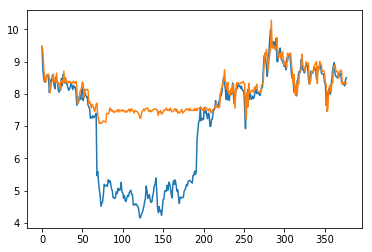

In [63]:
trained_rfr, score = trainModel(rfr, X_train, X_test, y_train, y_test)

## Regression

In [31]:
lm = LinearRegression()

In [71]:
scores = evaluateModel(lm, n_splits, X_train, y_train)
print(scores)

global_scores.append(scores)

test size is 151



[0.17023948212344128, 0.5409189436992357, 0.03905137383594702, 1.0875343144593894, 2.887103662716941, 0.11204175489770082, 0.08124438230441901, 0.08232928872370446, 0.13244876570499817, 0.4817282668374207]


score is  0.07614759576954827


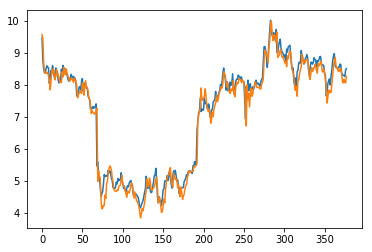

In [70]:
trained_linear, score = trainModel(lm, X_train, X_test, y_train, y_test)

## Arima

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

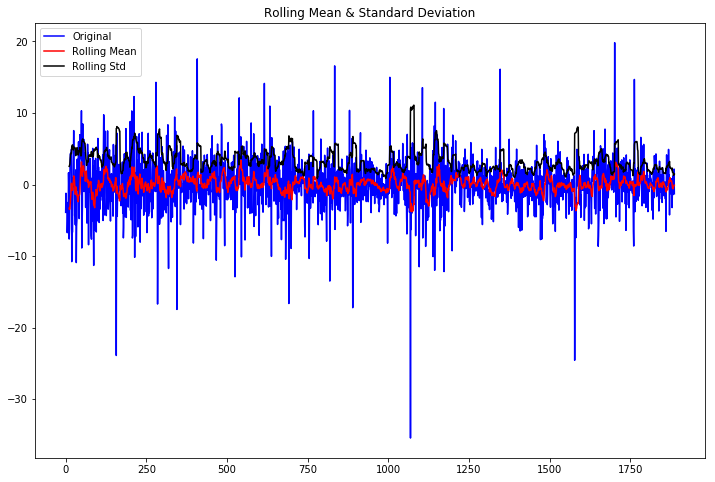

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -42.005214
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1887.000000
Critical Value (1%)              -3.433820
Critical Value (5%)              -2.863073
Critical Value (10%)             -2.567586
dtype: float64


In [10]:
test_stationarity(data_arima)

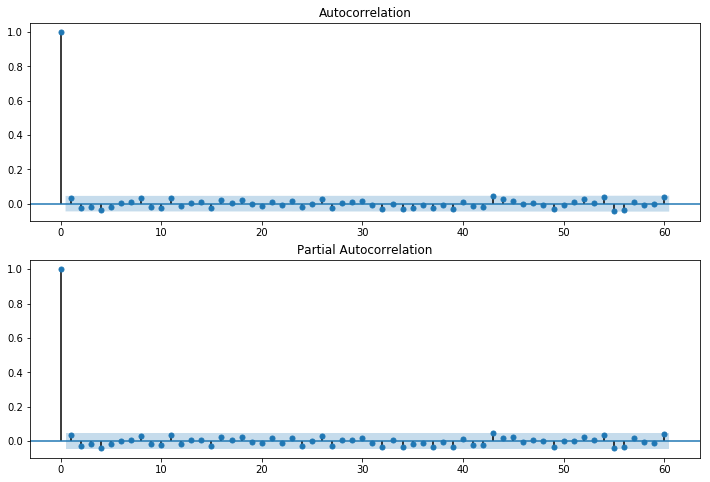

In [11]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_arima, lags=60, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_arima, lags=60, ax=ax2)# , lags=40

In [34]:
#AR term is 4, assume a weekly trend..?
print(data_arima.head(3))
arima = ARIMA(X_train_arima, order=(4,1,0))

0    18.60
1    18.75
2    18.00
Name: plus1_open, dtype: float64


In [72]:
p = 4
d = 1
q = 0

scores = evaluateArimaModel(p, d, q, n_splits, X_train_arima)
print(scores)

global_scores.append(scores)

test size is 151


c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar


[0.2736859295131596, 1.9103180371449255, 0.1494911457785276, 2.6935236692428393, 2.4917127495660187, 0.6434655201252024, 0.1692469459210994, 0.121674185355345, 0.1736232871739909, 0.29622532450625483]


c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
c:\users\limxu\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar


len of predicitons is  378
len of y_test is 378
score is  0.10055298544685407


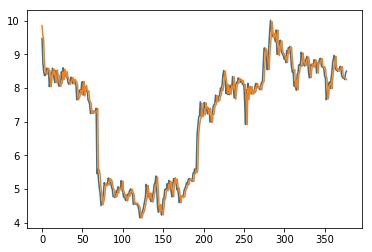

In [46]:
window = 5

trained_arima, score, predictions= trainModelArima(p,d,q, X_train_arima, y_test_arima, window, data_arima)

In [49]:
arima_predictions = pd.DataFrame(predictions, y_test)
print(arima_predictions)

                   0
plus1_open          
9.47        9.850626
8.75        9.549520
8.50        9.456747
8.37        8.773576
8.37        8.507013
8.50        8.427631
8.59        8.398466
8.55        8.507870
8.52        8.585021
8.04        8.532105
8.19        8.502362
8.44        8.038407
8.41        8.182782
8.59        8.473250
8.48        8.400545
8.25        8.556109
8.16        8.471812
8.52        8.229307
8.37        8.158405
8.41        8.531354
8.14        8.377842
8.05        8.372304
8.11        8.140879
8.13        8.042005
8.48        8.124322
8.25        8.135934
8.60        8.466098
8.48        8.242989
8.34        8.557632
8.49        8.487995
...              ...
8.62        8.637800
8.58        8.610383
8.35        8.633320
8.29        8.582108
7.65        8.346985
7.75        8.286757
8.03        7.670831
8.12        7.748978
8.18        8.076982
7.99        8.119765
8.27        8.147630
8.47        7.972407
8.76        8.252657
8.88        8.478185
8.97        8

In [74]:
file_name = "global_scores_plus1open.csv"
path = "C:/Users/limxu/OneDrive/Documents/UCB/SAAS/Project/scores/" + file_name
global_scores_df = pd.DataFrame(global_scores)
global_scores_df.to_csv(path)